In [26]:
#pip install tensorflow

In [27]:
from numpy.random import seed
seed(111)
import tensorflow as tf
tf.random.set_seed(111)

In [28]:
from tensorflow.keras import metrics
METRICS = [metrics.BinaryAccuracy(),
        metrics.Precision(name='precision'), 
        metrics.Recall(name='recall')]

## Load dataset

In [29]:
import pandas as pd
df = pd.read_csv("Team7_Restaurant_Reviews_Dataset.csv")
df.head()

,Review,Rating
0,Just had a meal here -started badly when my dr...,0
1,There's no need for social distancing at Level...,0
2,We had lunch here because it was an easy walk ...,0
3,This restaurant doesnt really stand out for an...,0
4,"Lured by the street menu, we visited this plac...",0


## Dataset includes 500 positive and 407 negative reviews.

In [30]:
df["Rating"].value_counts()

1    500
0    407
Name: Rating, dtype: int64

## Preprocessing

* Remove everything except letters
* Convert to lowercase
* Stemming

In [31]:
import nltk
nltk.download('stopwords')

import re
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
stopwords_english = stopwords.words('english')
preprocessed_data = []

for x in range(0, df.shape[0]):
    #Step 1: Remove everything except letters 
    reviews = re.sub('[^a-zA-Z]', ' ', df["Review"][x])
    
    #Step 2: Convert everything to lowercase
    reviews = reviews.lower()
    
    #Step 3: Stemming words with NLTK
    reviews = reviews.split() 
    reviews = [stemmer.stem(i) for i in reviews if i not in set(stopwords_english)] 
    reviews = ' '.join(reviews)
    preprocessed_data.append(reviews)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Below are the preprocessed tweets

In [32]:
preprocessed_data[:5]

['meal start badli driver came collect nice touch criticis footwear car set tone well seafood chowder came tini bowl smatter fish chunk probabl could pass seafood label accompani soup also serv half dozen oyster order came lemon dish balsam vinegar oyster could scallop tast virtual star attract scallop swim helplessli pool sauc ostens hide bland tast summis along chip salad offer ask want dessert whilst collect order bungl drink left order anoth tabl two collect girl possibl get order wrong left horribl underwhelm waiter told prior eat restaur among best auckland case get plane go back home wasnt ask enjoy pay offer come fall deaf ear come auckland u better sort roadsid cafe masquerad restaur',
 'need social distanc level serv quickli waiter pleasant meal came quickli mani peopl dine room take away order steak main garlic bread recommend us ok drink expens',
 'lunch easi walk lodg menu look better two adjac place crowd aka theori must better sinc peopl well look deceiv food seafood cho

## Split train and test set: %80 Train, %20 Test

In [33]:
# labels
y = df.iloc[:,1].values
# preprocessed data
X = preprocessed_data 
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, stratify=y)

In [34]:
print("X_train len: ", len(X_train))
print("y_train len: ", len(y_train))
print("X_test len: ", len(X_test))
print("y_test len: ", len(y_test))

X_train len:  725
y_train len:  725
X_test len:  182
y_test len:  182


In [35]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# maximum words in the vocabulary
max_words = 2500 
# maximum sequence length
max_len = 200 

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
# create sequences of tokens representing each sentence
training_sequences = tokenizer.texts_to_sequences(X_train) 
training_padded = pad_sequences(training_sequences, maxlen=max_len, truncating="post")
print("Training sequences:\n",training_padded)
# create sequences of tokens representing each sentence
testing_sequences = tokenizer.texts_to_sequences(X_test) 
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, truncating="post")
print("Testing sequences:\n",testing_padded)

X_train = training_padded
X_test = testing_padded


Training sequences:
 [[  0   0   0 ...  40  31  82]
 [  0   0   0 ...  24  11 142]
 [  0   0   0 ...  20  50 211]
 ...
 [  0   0   0 ... 244 280 272]
 [  0   0   0 ...  80  19 102]
 [  0   0   0 ...  30  99 271]]
Testing sequences:
 [[  0   0   0 ...  24  18   7]
 [  0   0   0 ... 148  20 120]
 [  0   0   0 ... 150  28  57]
 ...
 [  0   0   0 ...  80  19 102]
 [  0   0   0 ... 379  11   7]
 [  0   0   0 ... 150  28  57]]


##Confusion matrix visualization

In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def print_confusion_matrix(input):
    data = pd.DataFrame(input, columns=np.unique([0,1]), index = np.unique([0,1]))
    data.index.name = 'Actual'
    data.columns.name = 'Predicted'
    grp_names = ["True Neg","False Pos", "False Neg", "True Pos"]
    grp_counts = ["{0:0.0f}".format(value) for value in input.flatten()]
    grp_percentages = ["{0:.2%}".format(value) for value in input.flatten()/np.sum(input)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(grp_names,grp_counts,grp_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(data, annot=labels, fmt="", cmap='Blues')

# reference: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

In [37]:
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

## Train with LSTM


In [38]:
### ReLU and Sigmoid Activation Functions are being used
### Optimizer - RMS Prop
### Loss Criterion - Binary Cross Entropy Loss

### Structure - Embedding Layer -> LSTM Layers -> Dense Layers 
def lstm():
    model = Sequential()
    model.add(layers.Embedding(max_words, 45, input_length=max_len))

    model.add(layers.LSTM(256, return_sequences=True))
    model.add(layers.LSTM(216, return_sequences=True))
    model.add(layers.LSTM(152))
  
    model.add(layers.Dense(488, activation="relu"))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer="rmsprop",loss='binary_crossentropy', metrics=METRICS)
    model.summary()

    return model

In [39]:
lstm_model = lstm()
lstm_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
lstm_checkpoint = ModelCheckpoint("best_model1.hdf5", monitor='val_binary_accuracy', verbose=1,save_best_only=True, mode='auto',save_weights_only=False)
lstm_history = lstm_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[lstm_checkpoint, lstm_callback], batch_size=64)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 45)           112500    
                                                                 
 lstm_9 (LSTM)               (None, 200, 256)          309248    
                                                                 
 lstm_10 (LSTM)              (None, 200, 216)          408672    
                                                                 
 lstm_11 (LSTM)              (None, 152)               224352    
                                                                 
 dense_7 (Dense)             (None, 488)               74664     
                                                                 
 dense_8 (Dense)             (None, 1)                 489       
                                                                 
Total params: 1,129,925
Trainable params: 1,129,925
No

## Test trained LSTM model on test data

In [40]:
# Evaluate the model on the test data
print("Evaluate on test data")
lstm_result = lstm_model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc, test precion, test recall:", lstm_result)

Evaluate on test data
3/3 [==============================] - 3s 829ms/step - loss: 0.4045 - binary_accuracy: 0.9231 - precision: 0.9216 - recall: 0.9400
test loss, test acc, test precion, test recall: [0.40448421239852905, 0.9230769276618958, 0.9215686321258545, 0.9399999976158142]


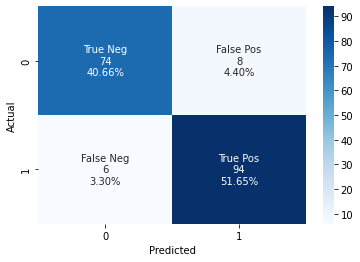

In [41]:
# Generate predictions/probabilities (the output of the last layer)
predictions = lstm_model.predict(X_test)

# to create confusion matrix transform probabilities to labels (if predicted more than 0.5 positivie-1 else negative-0 ))
y_pred = []
for i, predicted in enumerate(predictions):
    if predicted[0] >= 0.5:
        y_pred.append(1)
        #assign i to class 1
    else:
         y_pred.append(0)
        #assign i to class 0

# list to numpy array
y_pred = np.array(y_pred)

c = confusion_matrix(y_test, y_pred) 
print_confusion_matrix(c) 

##Train with CNN

In [42]:
### A CNN model is being built
### Using a 1D convolution
### ReLu activation function is being used
### Sigmoid Activation is being used
### Loss criterion - Binary Cross Entropy Loss

### Embedding Layer -> Conv1D Layers -> Flatten -> Dense Layer

### using model checkpoint to save and re-use the model later at higher validation accuracies
### Stop training when a monitored metric has stopped improving using Early Stopping
def cnn():
    model = Sequential()
    model.add(layers.Embedding(max_words, 35, input_length=max_len))

    model.add(layers.Conv1D(38, 2, activation='relu'))
    model.add(layers.Conv1D(26, 8, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1,activation='sigmoid'))

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)
    model.summary()

    return model

In [43]:
cnn_model = cnn()
cnn_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
cnn_checkpoint = ModelCheckpoint("best_model3.hdf5", monitor='val_binary_accuracy', verbose=1,save_best_only=True, mode='auto', save_weights_only=False)
cnn_history = cnn_model.fit(X_train, y_train, epochs=70, validation_split=0.2, callbacks=[cnn_checkpoint, cnn_callback])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 35)           87500     
                                                                 
 conv1d_2 (Conv1D)           (None, 199, 38)           2698      
                                                                 
 conv1d_3 (Conv1D)           (None, 192, 26)           7930      
                                                                 
 flatten_1 (Flatten)         (None, 4992)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                 4993      
                                                                 
Total params: 103,121
Trainable params: 103,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
19/19 [==============================

##Test trained CNN model on test data

In [44]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results3 = cnn_model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc, test precion, test recall:", results3)

Evaluate on test data
3/3 [==============================] - 0s 14ms/step - loss: 0.1780 - binary_accuracy: 0.8901 - precision: 0.8571 - recall: 0.9600
test loss, test acc, test precion, test recall: [0.17800481617450714, 0.8901098966598511, 0.8571428656578064, 0.9599999785423279]


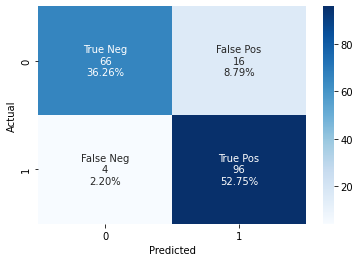

In [45]:
predictions = cnn_model.predict(X_test)

y_pred = []
for i, predicted in enumerate(predictions):
    if predicted[0] >= 0.5:
        y_pred.append(1)
        #assign i to class 1
    else:
         y_pred.append(0)
        #assign i to class 0

y_pred = np.array(y_pred)

c = confusion_matrix(y_test, y_pred)
print_confusion_matrix(c)